# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 12.10.2024

Мягкий дедлайн: 23:59MSK 27.10.2024

Жесткий дедлайн: 23:59MSK 31.10.2024

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
import folium

m = folium.Map(location=(50.97178, 9.79418), zoom_start=15)

m

Если вы всё сделали правильно, то выше должна открыться карта

### 📌 **Памятка по дз2**

Обрабатывать данные можно любым способом (`polars`, `pandas`, `pyspark`, ...), который вам нравится и запускается в ноутбуке, и любой библиотекой для визуализации (`matplotlib`, `seaborn`, `plotly`, ...). Пользуйтесь на здоровье, но!

> Учтите, что `polars` всё ещё молодой и не все библиотеки его поддерживают. `sklearn` во многом уже работает, но на всякий случай не стесняйтесь пользоваться методами `pl.DataFrame.to_pandas()` или `pl.DataFrame.to_numpy()`    

> Впрочем, `pandas` тоже не лишён проблем. `sklearn` принимает `pd.DataFrame` почти везде, проблемы очень редки, но если вдруг возникнет какая-то беда с шейпами, или ещё какой-нибудь казус, а вы уверены, что всё правильно, пользуйтесь `pd.DataFrame.to_numpy()`. Это не всегда решает проблему, но часто помогает понять, что на самом деле не так. При желании можно передавать и `Iterable`, и sparse-матрицы

> Графики должны быть понятные, читаемые и пр. Консультируйтесь с памяткой из дз1 в задании на график

> Для воспроизводимости результатов не забывайте пользоваться `np.random.seed(...)`, при необходимости чистите мусор `gc.collect()`, лучше в каждой ячейке

> Все результаты должны быть получены в ноутбуке. На каждый **Вопрос** долен быть дан **Ответ** (письменно (в Markdown например) или кодом)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [3]:
df = pd.read_csv('/Users/syuy/Desktop/train.csv')
# test = pd.read_csv('/Users/syuy/Desktop/test.csv')

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [4]:
df = df.loc[:,~df.columns.isin(['dropoff_datetime'])]
df.pickup_datetime = pd.to_datetime(df.pickup_datetime, format='%Y-%m-%d %H:%M:%S')
# test.pickup_datetime = pd.to_datetime(test.pickup_datetime, format='%Y-%m-%d %H:%M:%S')
df.head(3)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


In [5]:
df.trip_duration.max(), df.trip_duration.median()
# макс длительность поездки и медианная длительность, все в секундах

(3526282, 662.0)

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

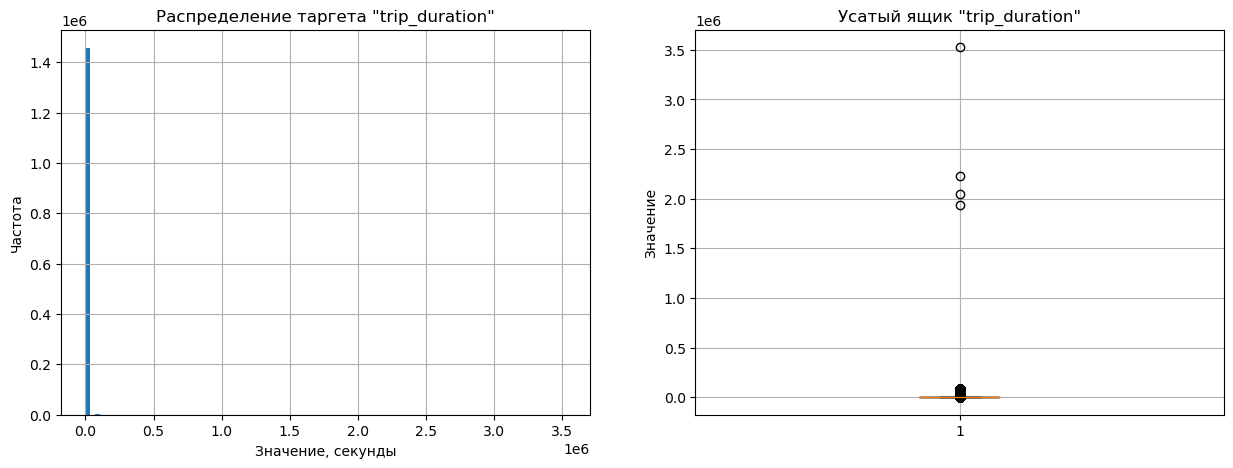

In [6]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.title('Распределение таргета "trip_duration"')
plt.xlabel('Значение, секунды')
plt.ylabel('Частота')
plt.hist(df.trip_duration, bins = 100);
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Усатый ящик "trip_duration"')
plt.ylabel('Значение')
plt.boxplot(df.trip_duration);
plt.grid()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

Основная масса таргета распределена в небольшом диапазоне, есть немного экстра выбросов, но в остальном все достаточно близко друг к другу. Мы анализируем длительность поездки на такси NYC, так как выбросов немного то можно предположить что в основном заказывают такси на короткие-средние расстояния. Помним, что таргет у нас в секундах, поэтому у гистаграммы внушительные значения по Оу.

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: при работе с бесконечно малыми функциями можем свести запись под корнем к разности у факт и у предсказанного, это вид рмсе. А минимизация рмсе эквивалентна минимизации мсе, так как первое это просто корень квадратный из второго.

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [7]:
df['log_trip_duration'] = np.log1p(df.trip_duration)
df = df.drop(['trip_duration'],axis = 1)
df.head(3)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527


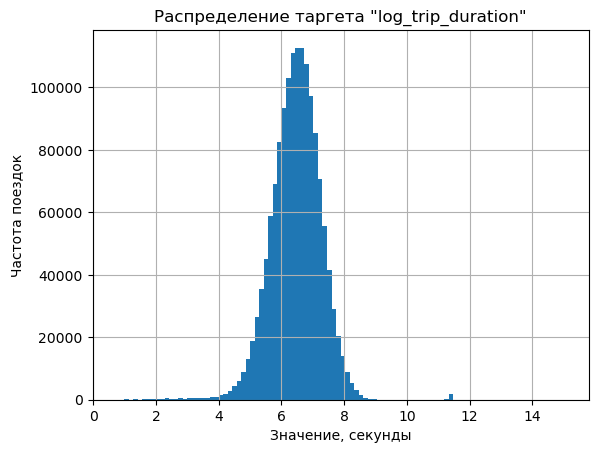

In [8]:
plt.title('Распределение таргета "log_trip_duration"')
plt.xlabel('Значение, секунды')
plt.ylabel('Частота поездок')

plt.hist(df.log_trip_duration, bins = 100);
plt.grid()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [9]:
def rmsle(log1p_y_true, log1p_y_pred):
    return np.sqrt(np.mean((log1p_y_true - log1p_y_pred)**2))

rmsle_best_const = rmsle(df.log_trip_duration, df.log_trip_duration.mean())
print(f'RMSLE Test conts predict: {rmsle_best_const}')
assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

# Лучший константный прогноз - среднее

RMSLE Test conts predict: 0.7957592365411509


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году:

In [10]:
gr_month = df['pickup_datetime'].dt.month
gr_hour = df['pickup_datetime'].dt.hour
gr_dow = df['pickup_datetime'].dt.dayofweek
gr_date = df['pickup_datetime'].dt.date

In [11]:
dates_cnt= df.groupby(gr_date).count()['id']
two_min = pd.DataFrame(dates_cnt.sort_values()).iloc[:2, :]
two_min  # нашли две экстремальные даты по количеству поездок

,id
pickup_datetime,
2016-01-23,1648
2016-01-24,3383


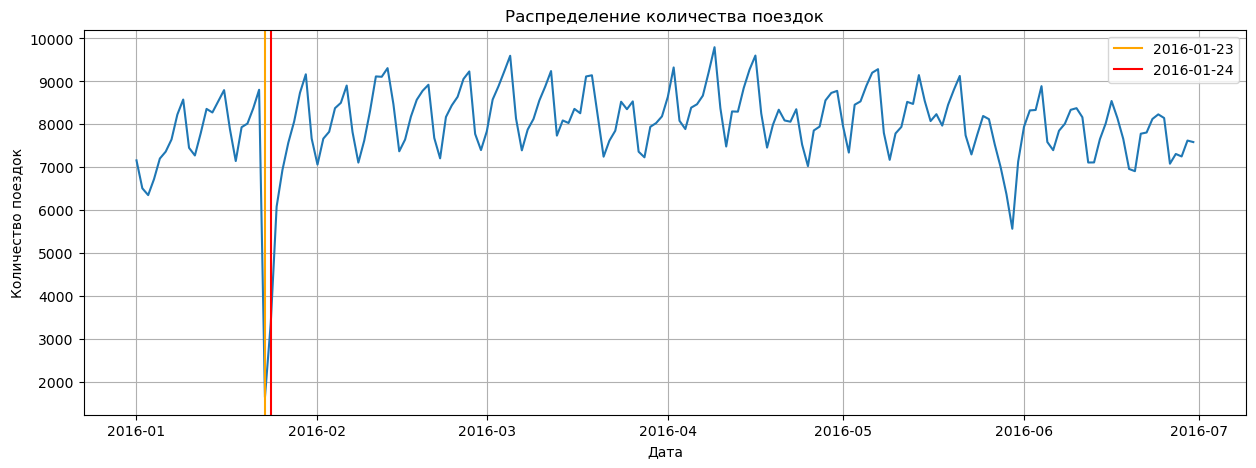

In [12]:
plt.figure(figsize = (15,5))
plt.title('Распределение количества поездок')
plt.xlabel('Дата')
plt.ylabel('Количество поездок')

plt.plot(dates_cnt);
plt.axvline(x=two_min.index[0], color='orange', label = two_min.index[0]);
plt.axvline(x=two_min.index[1], color='red', label = two_min.index[1]);
plt.grid()
plt.legend();

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках:

 В это время была снежная буря, движение на дорогах ограничено https://en.wikipedia.org/wiki/January_2016_United_States_blizzard. Выделено рыжим на графике выше

In [13]:
weekdays_cnt= df.groupby(gr_dow).count()['id']
hours_cnt= df.groupby(gr_hour).count()['id']

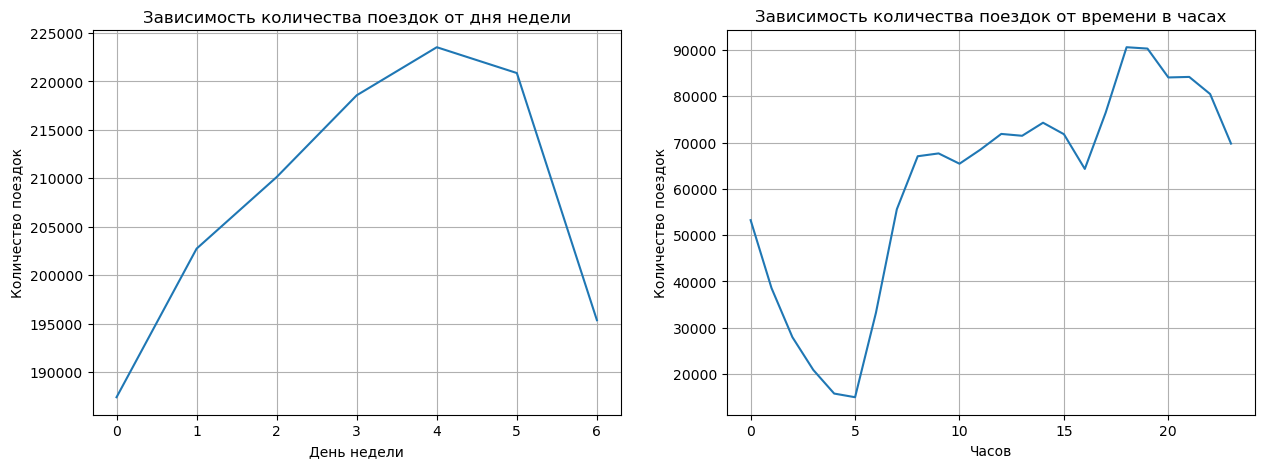

In [14]:
plt.figure(figsize = (15, 5))

plt.subplot(1,2,1)
plt.title('Зависимость количества поездок от дня недели')
plt.xlabel('День недели')
plt.ylabel('Количество поездок')
plt.plot(weekdays_cnt);
plt.grid();

plt.subplot(1,2,2)
plt.title('Зависимость количества поездок от времени в часах')
plt.xlabel('Часов')
plt.ylabel('Количество поездок')
plt.plot(hours_cnt);
plt.grid();


**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, поищите, как это делается). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

In [15]:
month_hour = df.groupby([gr_month, gr_hour]).agg('count')['id']
hour_dow = df.groupby([gr_dow, gr_hour]).agg('count')['id']

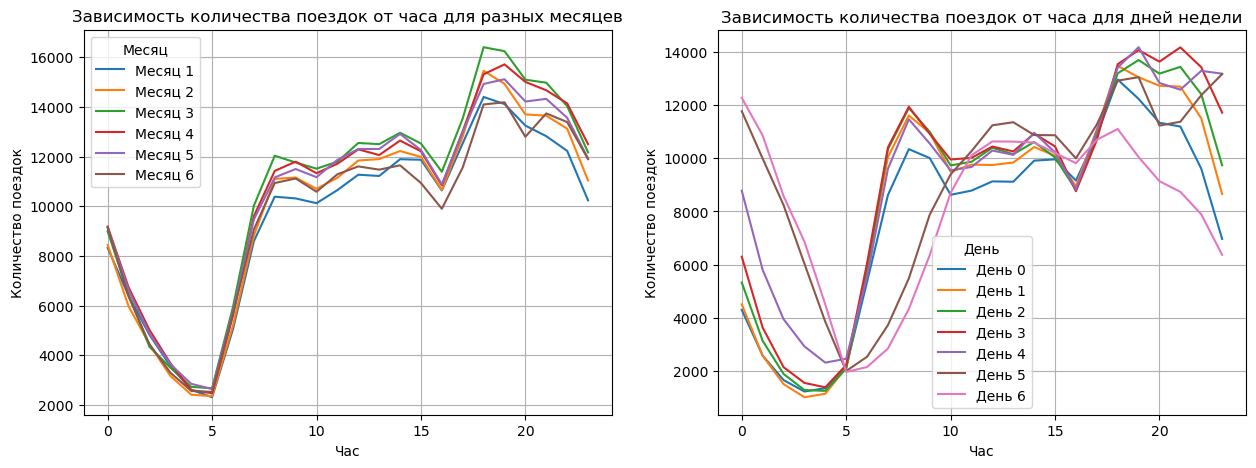

In [16]:
plt.figure(figsize = (15, 5))

plt.subplot(1,2,1)
hour_month = month_hour.unstack().T
for month in pd.DataFrame(hour_month).columns:
    plt.plot(hour_month.index, hour_month[month], label=f"Месяц {month}")
plt.title("Зависимость количества поездок от часа для разных месяцев")
plt.xlabel("Час")
plt.ylabel("Количество поездок")
plt.legend(title="Месяц")
plt.grid()

plt.subplot(1,2,2)
hour_dow = hour_dow.unstack().T
for dow in pd.DataFrame(hour_dow).columns:
    plt.plot(hour_dow.index, hour_dow[dow], label=f"День {dow}")
plt.title("Зависимость количества поездок от часа для дней недели")
plt.xlabel("Час")
plt.ylabel("Количество поездок")
plt.legend(title="День")
plt.grid()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?


Количество поездок по часам примерно одинаково во все рассмотренные 6 месяцев (график слева). Про дни недели: нумерация начинается с 0 - пн и до 6 - вс, можно заметить, что в 6 - вс количество заказов такси в дневное и вечернее время меньше чем в другие дни, зато в ночное время количество поездок резко вырастает. В 5 - сб наблюдаем похожий тренд, только там спрос на такси большой и ночью, и вечером. Люди часто выбираются гулять на выходных, а именно гуляют с вечера субботы и могут поздно возвращаться домой (уже ночь воскресенья). В будни все примерно одинаково заказывают такси.

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [17]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size = 0.3, random_state=42)

In [18]:
mean_dow = train_df.groupby(gr_dow)['log_trip_duration'].mean()
mean_hour = train_df.groupby(gr_hour)['log_trip_duration'].mean()
mean_date = train_df.groupby(gr_date)['log_trip_duration'].mean()

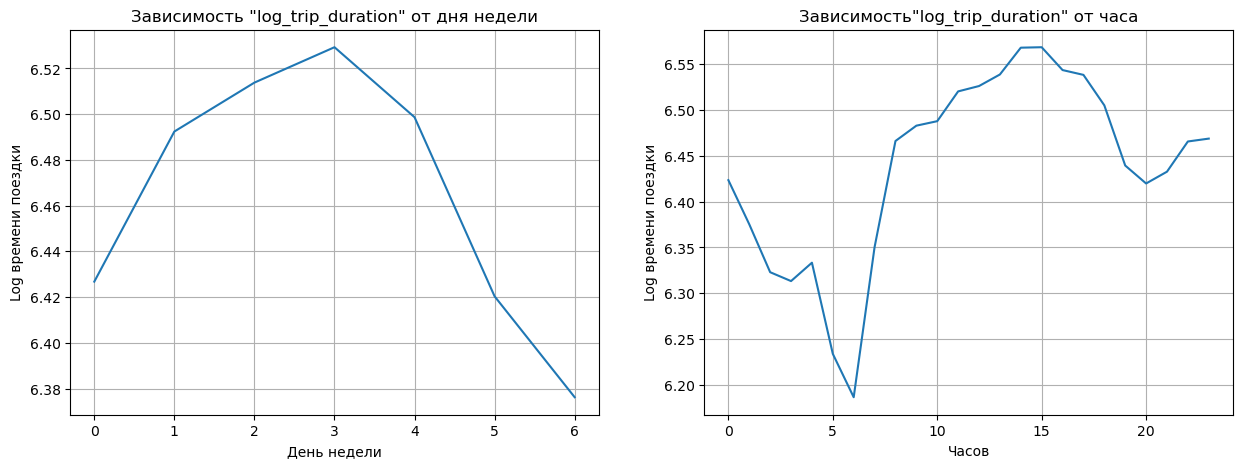

In [19]:
plt.figure(figsize = (15, 5))

plt.subplot(1,2,1)
plt.title('Зависимость "log_trip_duration" от дня недели')
plt.xlabel('День недели')
plt.ylabel('Log времени поездки')
plt.plot(mean_dow);
plt.grid();

plt.subplot(1,2,2)
plt.title('Зависимость"log_trip_duration" от часа')
plt.xlabel('Часов')
plt.ylabel('Log времени поездки')
plt.plot(mean_hour);
plt.grid();

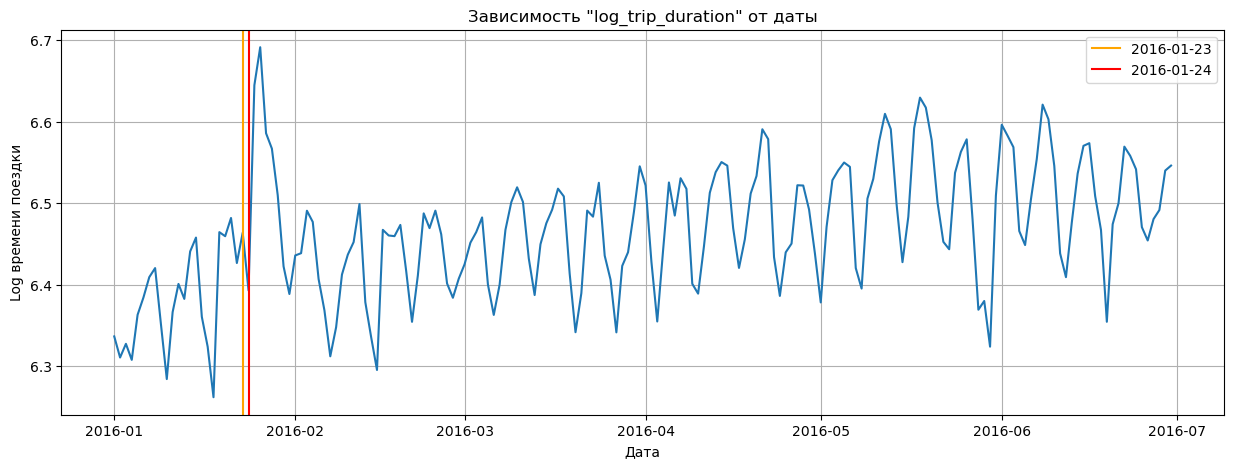

In [20]:
plt.figure(figsize = (15,5))
plt.title('Зависимость "log_trip_duration" от даты')
plt.xlabel('Дата')
plt.ylabel('Log времени поездки')
plt.plot(mean_date);
plt.axvline(x=two_min.index[0], color='orange', label = two_min.index[0]);
plt.axvline(x=two_min.index[1], color='red', label = two_min.index[1]);
plt.grid();
plt.legend();

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

1) Графики среднего таргета и количества поездок от дня недели ассиметричны. Графики зависимости этих двух признаков от часа похожи визуально немного: чем больше заказов тем больше среднее время поездки, так как пробки. 
2) Средний таргет в два дня снежной бури просел, отметила на графике
3) Виден слабый восходящий тренд по графику динамики таргета, люди стали больше времени проводить в дороге в среднем. Нью Йорк не резиновый. 

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [21]:
# два выброса по количеству заказов
kek = two_min.index

# добавляем день недели и факт аномалии
gr_dayofyear = np.array(df['pickup_datetime'].dt.dayofyear)
is_jump = np.array(gr_date.isin(kek))

# признаки живут в отдельном домике пока 
new_features = pd.DataFrame({'dow': gr_dow, 'month': gr_month, 'hour': gr_hour, 'is_jump': is_jump, 'day_num': gr_dayofyear})
new_features.head(3)

,dow,month,hour,is_jump,day_num
0,0,3,17,False,74
1,6,6,0,False,164
2,1,1,11,False,19


Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

In [22]:
new_features.dtypes

dow        int64
month      int64
hour       int64
is_jump     bool
day_num    int64
dtype: object

Категориальные признаки: dow, month, is_jump

Численные: day_num, hour

Hour, в целом, подходит в оба варианта

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [23]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

cat_cols = ['dow', 'month', 'is_jump']
num_cols = ['hour', 'day_num']

X_train, X_test, y_train, y_test = train_test_split(new_features, df.log_trip_duration, test_size = 0.3, 
                                                     random_state=42)
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='if_binary'), cat_cols)
])

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regression', Ridge())
])

pipeline.fit(X_train, y_train)
y_pred_test_r = pipeline.predict(X_test)
y_pred_train_r = pipeline.predict(X_train)

In [24]:
print('Ridge 1 на 5 признаках')
print(f'RMSLE Train_1: {rmsle(y_train, y_pred_train_r)}')
print(f'RMSLE Test_1: {rmsle(y_test, y_pred_test_r)}')

Ridge 1 на 5 признаках
RMSLE Train_1: 0.7929024655734366
RMSLE Test_1: 0.7919458444407417


Добавляем новые признаки в основную таблицу

In [25]:
df = df.join(new_features)
df.head(3)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,dow,month,hour,is_jump,day_num
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493,0,3,17,False,74
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282,6,6,0,False,164
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527,1,1,11,False,19


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [26]:
from typing import Iterable

def show_circles_on_map(
    latitude_values: Iterable[float],
    longitude_values: Iterable[float],
    color: str = "blue",
) -> folium.Map:
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    Works best on samples of size < 10k, too costly otherwise

    latitude_values: sample latitude values of a dataframe
    longitude_column: sample longitude values of a dataframe
    color: the color of circles to be drawn
    """

    location = (np.mean(latitude_values), np.mean(longitude_values))
    m = folium.Map(location=location)

    for lat, lon in zip(latitude_values, longitude_values):
        folium.Circle(
            radius=100,
            location=(lat, lon),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

Напишите функция, которая вернет значения колонок `pickup_latitude`, `pickup_longitude` на каком-нибудь разумном кусочке датафрейма, например, `df.sample(1000)` и покажите на карте, используя `show_circles_on_map`

In [27]:
# Рисую выборку из трейна, тест не будем трогать

# это точки где сели на борт
sample = train_df.sample(800)
show_circles_on_map(sample.pickup_latitude, sample.pickup_longitude, color="blue")

In [28]:
# это точки десантирования
sample = train_df.sample(800)
show_circles_on_map(sample.dropoff_latitude, sample.dropoff_longitude, color="red")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

Большое скопление: Район Манхэттен в совокупности, центр города.

Небольшие скопления: Международный аэропорт имени Джона Кеннеди, Аэропорт Ла-Гвардия. Системные точки, а завтра в 7:22 я буду ля ля ля сидеть в самолете. Аэропорты по классике удалены от центра города, и если мы знаем, что такси выехало из аэропорта, то вероятней всего вы едем в центр, и можно примерно рассчитать время поездки при прочих равных)))

В целом, ясен расклад точечная масса большая на острове Манхэттен, как Коссова говорила, вот у вас есть куча песка вы сидите в песочнике и сыпете песок в горку. Так и здесь есть какие то хвосты, но центр тяжести распределения виден отчетливо.

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [29]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

Далее возвращаемся к нашей изначальной таблице train, она содержит как трейн, так и тест наборы. Мы снова работаем со всей таблицей

In [30]:
df['haversine'] = haversine_array(df.pickup_latitude.values, 
                df.pickup_longitude.values, 
                df.dropoff_latitude.values, 
                df.dropoff_longitude.values)
df.head(3)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,dow,month,hour,is_jump,day_num,haversine
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493,0,3,17,False,74,1.498521
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282,6,6,0,False,164,1.805507
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527,1,1,11,False,19,6.385098


Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [31]:
df['log_haversine'] = np.log1p(df.haversine)
df.head(3)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,dow,month,hour,is_jump,day_num,haversine,log_haversine
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493,0,3,17,False,74,1.498521,0.915699
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282,6,6,0,False,164,1.805507,1.031584
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527,1,1,11,False,19,6.385098,1.999464


Посчитайте корреляцию и убедитесь, что логарифм расстояния лучше отражает таргет, чем просто расстояние:

In [32]:
df[['haversine', 'log_haversine']].corrwith(df['log_trip_duration'])
# for sure

haversine        0.573595
log_haversine    0.749882
dtype: float64

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

Средняя скорость поездки в км/ч: 12.791978575882858


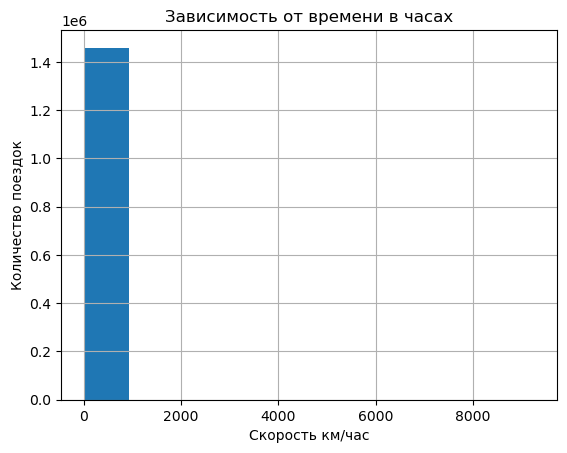

In [33]:
trip_duration = (np.exp(df.log_trip_duration)-1) # время в secs, перевод из логарифма
mean_speed = df.haversine/(trip_duration/3600) # перевела время в часы
print(f'Средняя скорость поездки в км/ч: {mean_speed.median()}')

plt.title('Зависимость от времени в часах')
plt.xlabel('Скорость км/час')
plt.ylabel('Количество поездок')
plt.hist(mean_speed);
plt.grid();

In [34]:
mean_speed.sort_values(ascending=False)

1176337    9274.836731
910072     6877.340406
184925     5640.493985
974378     5251.015993
377068     4086.712020
              ...     
1221828       0.000000
1167213       0.000000
550245        0.000000
858623        0.000000
25530         0.000000
Length: 1458644, dtype: float64

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

In [35]:
q3 = np.quantile(mean_speed, q = 0.75)
q1 = np.quantile(mean_speed, q = 0.25)
border_right = q3 + 1.5*(q3-q1)
print(f'Это верхняя граница км/ч: {border_right}')
# по классике, полтора интерквартильного размаха

Это верхняя граница км/ч: 30.930369206310022


Все значения выше будем считать выбросами и не будем учитывать их при построении графиков.

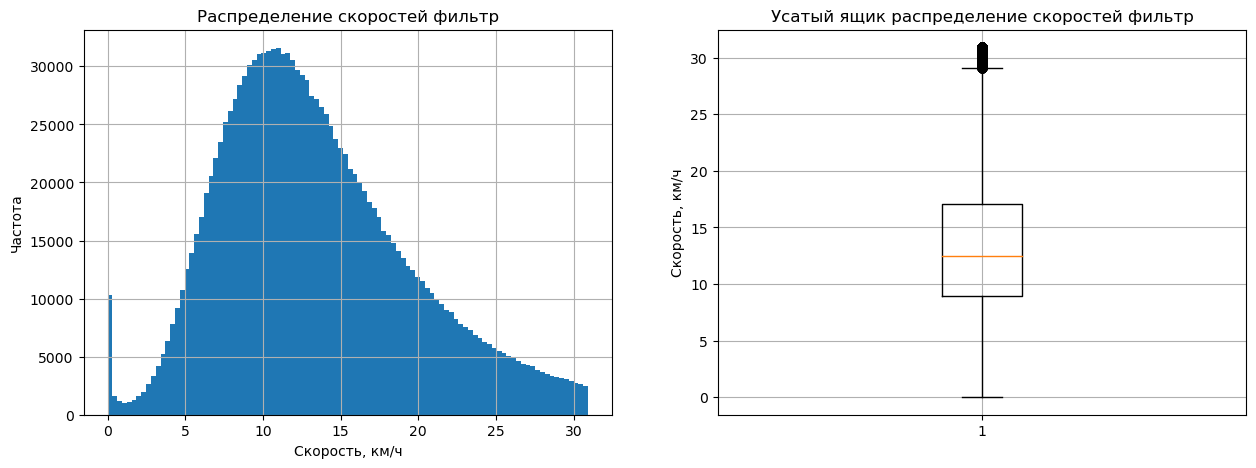

In [36]:
plt.figure(figsize=(15,5))
plt.suptitle('')

plt.subplot(1, 2, 1)
plt.title('Распределение скоростей фильтр')
plt.xlabel('Скорость, км/ч')
plt.ylabel('Частота')
plt.hist(mean_speed[mean_speed<=border_right], bins = 100);
plt.grid()


plt.subplot(1, 2, 2)
plt.title('Усатый ящик распределение скоростей фильтр')
plt.ylabel('Скорость, км/ч')
plt.boxplot(mean_speed[mean_speed<=border_right]);
plt.grid()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте Heatmap-график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [37]:
draft_df = df.copy() # чтобы не пачкать основную таблицу

In [38]:
draft_df['mean_speed'] = mean_speed
heatmap_base = pd.DataFrame(draft_df.groupby([gr_dow, gr_hour]).mean_speed.median()).unstack()
# heatmap_base.head(3)

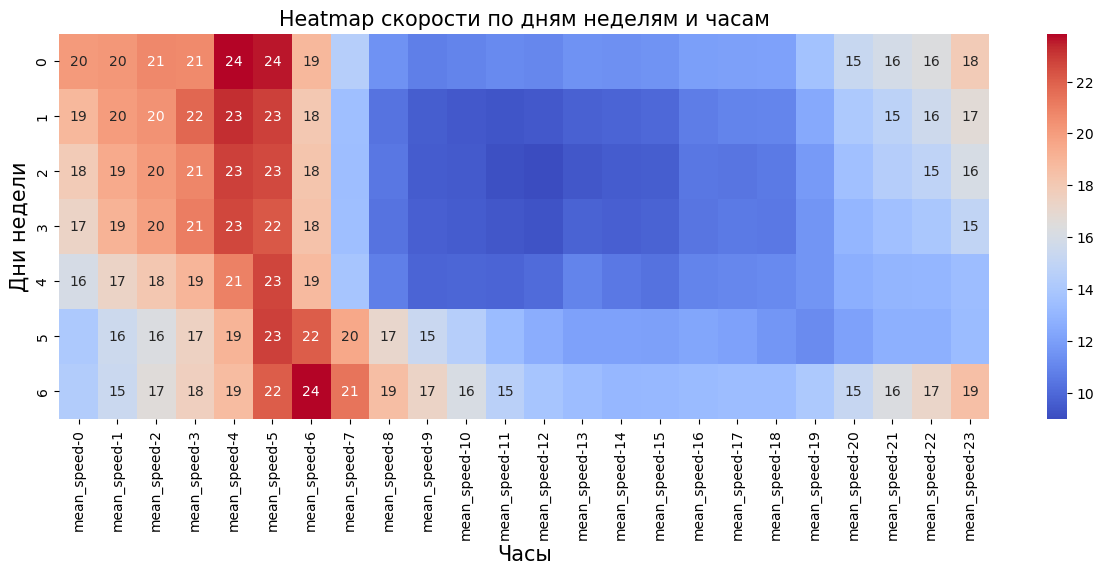

In [39]:
import seaborn as sns

plt.figure(figsize = (15,5))
heatmap = sns.heatmap(heatmap_base, cmap='coolwarm', annot=True);
heatmap.set_title('Heatmap скорости по дням неделям и часам', fontsize = 15);
plt.xlabel('Часы', fontsize = 15)
plt.ylabel('Дни недели', fontsize = 15)


# мб приятней смотреть будет
for i in heatmap.texts:
    if float(i.get_text())>=15:
        i.set_text(i.get_text())
    else:
        i.set_text("")

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

Нет, так как при расчете скорости используется само значение таргета, утечка данных просходит

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

Скорость минимальна по будням примерно с 7 часов (утренний час пик) и до 20-21 часов вечера, максимальна в ночное время, так как большая часть населения спит и трафик на дорогах низкий. В выходные так же меньше берут такси, чем в будние дни

In [40]:
df['probka']= (gr_dow<5)&((gr_hour>=7)&(gr_hour<21))
df['free_ride']=((gr_hour>=23)&(gr_hour<7)|(gr_dow>= 5))

**Задание 8 (0.25 балла)**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака:
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

In [41]:
def is_near(params, radius):
    place = np.tile(params, (df.shape[0],1))
    start = df[['pickup_longitude', 'pickup_latitude']]
    finish= df[['dropoff_longitude', 'dropoff_latitude']]
    kek = np.hstack((place, finish))
    lol = np.hstack((place, start))
    start_res = haversine_array(lol.T[3], lol.T[2], lol.T[1], lol.T[0])<=radius
    finish_res = haversine_array(kek.T[3], kek.T[2], kek.T[1], kek.T[0])<=radius
    return start_res, finish_res

In [42]:
# для аэропорта Кеннеди, координаты искала по картам, последние элемент это радиус, по встроенной линейке смотрела
one, two = is_near(np.array([-73.778502, 40.642019]), 3.5)

# для аэропорта ла гвардия
three, four = is_near(np.array([-73.869164, 40.775426]), 2.5)

In [43]:
df[['start_in_ken','finist_in_ken']] = np.column_stack((one, two))
df[['start_in_lagvard','finist_in_lagvard']] = np.column_stack((three, four))

Для каждого из созданных признаков нарисуйте "ящик с усами" (aka boxplot) распределения логарифма времени поездки

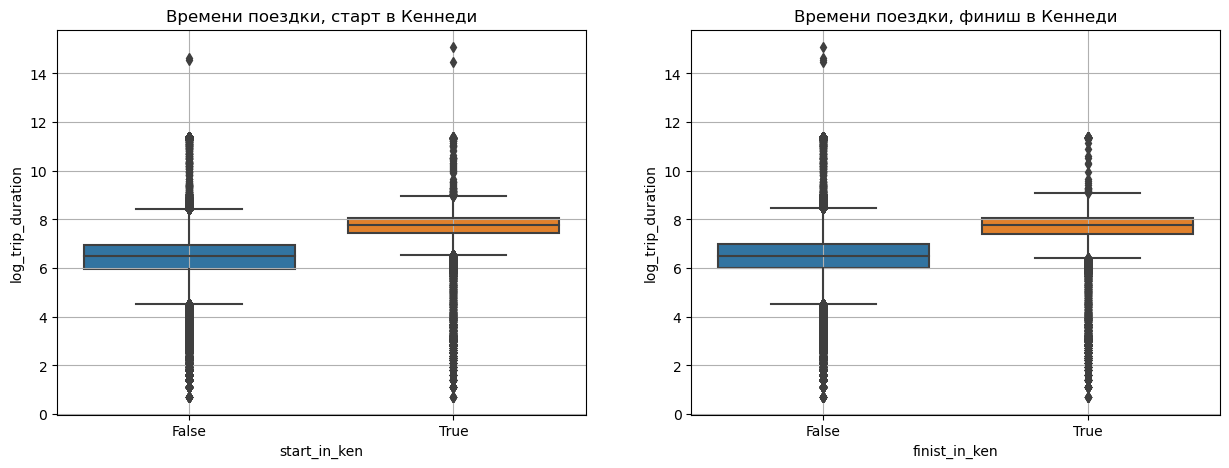

In [44]:
plt.figure(figsize = (15, 5))

plt.subplot(1,2,1)
plt.title('Времени поездки, старт в Кеннеди')
sns.boxplot(x = 'start_in_ken',y = 'log_trip_duration', data = df)
plt.grid();

plt.subplot(1,2,2)
plt.title('Времени поездки, финиш в Кеннеди')
sns.boxplot(x = 'finist_in_ken',y = 'log_trip_duration', data = df)
plt.grid();

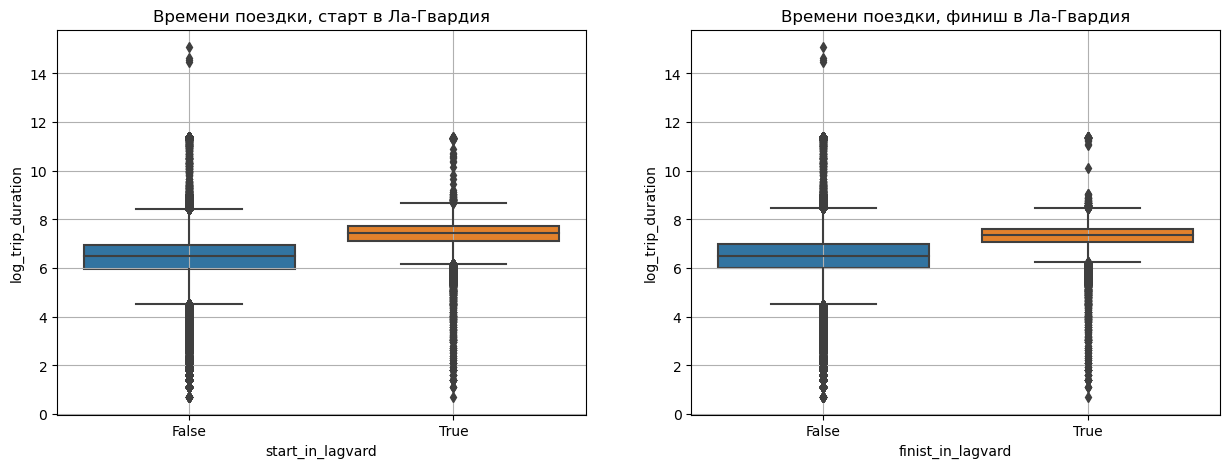

In [45]:
plt.figure(figsize = (15, 5))

plt.subplot(1,2,1)
plt.title('Времени поездки, старт в Ла-Гвардия')
sns.boxplot(x = 'start_in_lagvard',y = 'log_trip_duration', data = df)
plt.grid();

plt.subplot(1,2,2)
plt.title('Времени поездки, финиш в Ла-Гвардия')
sns.boxplot(x = 'finist_in_lagvard',y = 'log_trip_duration', data = df)
plt.grid();

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

На первый взгляд кажется, что ок. В среднем логарифм времени больше в случае если поездка имеет связь с аэропортом. Есть много направлений и можно в разные места кататься, но можно предположить, что если мы едем из или в аэропорт, в центр, то это будет больше времени занимать, чем если бы мы катались по рызным точкам в центре. Просто аэропорты как правило находятся в области

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [46]:
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_rows = 4, n_cols = 3, cell_width = 0.01, cell_height=0.01):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.cell_width = cell_width
        self.cell_height = cell_height

    def fit(self, X, y=None):
        center_lat, center_lon = X[['pickup_latitude', 'pickup_longitude']].median().values
        self.min_lat = center_lat - self.n_rows/2*self.cell_height
        self.max_lat = center_lat + self.n_rows/2*self.cell_height
        self.min_lon = center_lon - self.n_cols/2*self.cell_width
        self.max_lon = center_lon + self.n_cols/2*self.cell_width
        return self
    

    def transform(self, X, y=None):
        pickup_row = np.ceil((X['pickup_latitude'] - self.min_lat) / self.cell_height)
        pickup_col = np.ceil((X['pickup_longitude'] - self.min_lon) / self.cell_width)
        dropoff_row = np.ceil((X['dropoff_latitude'] - self.min_lat) / self.cell_height)
        dropoff_col = np.ceil((X['dropoff_longitude'] - self.min_lon) / self.cell_width)

        pickup_inside = (
            (X['pickup_latitude'] >= self.min_lat) & (X['pickup_latitude'] <= self.max_lat) &
            (X['pickup_longitude'] >= self.min_lon) & (X['pickup_longitude'] <= self.max_lon))
        dropoff_inside = (
            (X['dropoff_latitude'] >= self.min_lat) & (X['dropoff_latitude'] <= self.max_lat) &
            (X['dropoff_longitude'] >= self.min_lon) & (X['dropoff_longitude'] <= self.max_lon))

        X_copy = X.copy()
        X_copy['pickup_cell'] = np.where(pickup_inside, (pickup_row-1) * self.n_cols + pickup_col, -1)
        X_copy['dropoff_cell'] = np.where(dropoff_inside, (dropoff_row-1) * self.n_cols + dropoff_col, -1)
        return X_copy
        
        
    def show_map(self, sample = None):
        # центральная точка
        map_grid = folium.Map(location=[self.min_lat + (self.n_rows / 2) * self.cell_height, 
                                         self.min_lon + (self.n_cols / 2) * self.cell_width], zoom_start=13)
        
# добавляем круги для координат из выборки
# это дополнительный кусок, использовался для отладки работы клеток прямоугольника
# можно оставить,просто прикольная визуализация

#         for lat, lon in zip(sample['pickup_latitude'], sample['pickup_longitude']):
#             folium.CircleMarker(
#                 location=[lat, lon],
#                 radius=3,
#                 color="blue",
#                 fill=True,
#                 fill_opacity=0.7
#             ).add_to(map_grid)

        # рисуем домик для точек
        for row in range(self.n_rows):
            for col in range(self.n_cols):
                lat_bottom = self.min_lat + row * self.cell_height
                lat_top = self.min_lat + (row + 1) * self.cell_height
                lon_left = self.min_lon + col * self.cell_width
                lon_right = self.min_lon + (col + 1) * self.cell_width
                folium.Rectangle(
                    bounds=[[lat_bottom, lon_left], [lat_top, lon_right]],
                    color='blue',
                    fill=True,
                    fill_opacity=0.1
                ).add_to(map_grid)
        return map_grid
    
# кусок с методом show_map был написан при поддержке чата гпт, 
# я хотела проверить попадания точек из рандомной выборки в клетки, домик для точек тоже рисовал он, 
# но под моим чутким руководством

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [47]:
# удалим лишние признаки id, pickup_datetime, haversine, это дубли или мусорные
# df.head(3)
cols_to_drop = ['id','pickup_datetime', 'haversine']
df=df[df.columns[~df.columns.isin(cols_to_drop)]]

In [48]:
# vendor_id, vendor_id - по условию будем рассматривать позже
# log_trip_duration - таргет

X, y  = df.drop(['vendor_id','passenger_count', 'log_trip_duration'], axis = 1), df.log_trip_duration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [49]:
columns_to_drop = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

transformer = MapGridTransformer()
X_train = transformer.fit_transform(X_train).drop(columns_to_drop, axis = 1)
X_test = transformer.transform(X_test).drop(columns_to_drop, axis = 1)

In [50]:
cat_cols = ['probka', 'free_ride', 'start_in_ken', 'finist_in_ken', 'start_in_lagvard', 
            'finist_in_lagvard', 'dow', 'month', 'is_jump','pickup_cell', 'dropoff_cell']
num_cols = ['log_haversine', 'hour', 'day_num']

preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='if_binary'), cat_cols)
])

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regression', Ridge())
])

pipeline.fit(X_train, y_train)
y_pred_test_r2 = pipeline.predict(X_test)
y_pred_train_r2 = pipeline.predict(X_train)

In [51]:
print(f'RMSLE Train_2: {rmsle(y_train, y_pred_train_r2)}')
print(f'RMSLE Test_2: {rmsle(y_test, y_pred_test_r2)}')

RMSLE Train_2: 0.4882644004867274
RMSLE Test_2: 0.4876630657637458


Стало лучше :)))

In [52]:
df = transformer.transform(df).drop(columns_to_drop, axis = 1)
df.head(3)

,vendor_id,passenger_count,store_and_fwd_flag,log_trip_duration,dow,month,hour,is_jump,day_num,log_haversine,probka,free_ride,start_in_ken,finist_in_ken,start_in_lagvard,finist_in_lagvard,pickup_cell,dropoff_cell
0,2,1,N,6.122493,0,3,17,False,74,0.915699,True,False,False,False,False,False,11.0,-1.0
1,1,1,N,6.498282,6,6,0,False,164,1.031584,False,True,False,False,False,False,2.0,-1.0
2,2,1,N,7.661527,1,1,11,False,19,1.999464,True,False,False,False,False,False,8.0,-1.0


В табличке новые признаки, транформер уже обучился на трейне, применим его ко всей таблице сразу, чтобы дальше не приходилось постоянно его использовать

## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [53]:
df[['vendor_id','passenger_count','store_and_fwd_flag']].nunique()

vendor_id              2
passenger_count       10
store_and_fwd_flag     2
dtype: int64

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

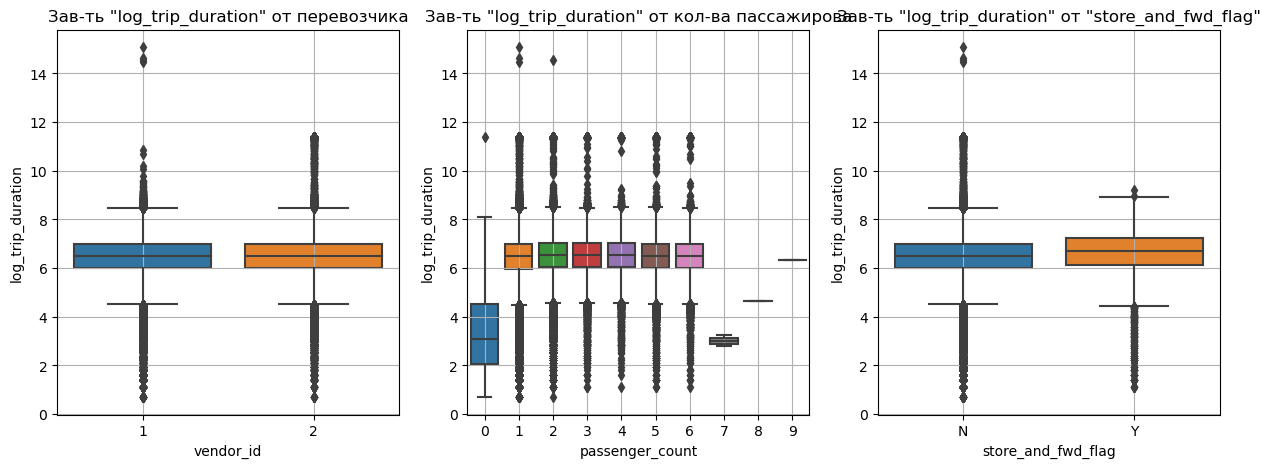

In [54]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title('Зав-ть "log_trip_duration" от перевозчика')
sns.boxplot(x = 'vendor_id',y = 'log_trip_duration', data = df)
plt.grid();

plt.subplot(1,3,2)
plt.title('Зав-ть "log_trip_duration" от кол-ва пассажирова')
sns.boxplot(x = 'passenger_count',y = 'log_trip_duration', data = df)
plt.grid();

plt.subplot(1,3,3)
plt.title('Зав-ть "log_trip_duration" от "store_and_fwd_flag"')
sns.boxplot(x = 'store_and_fwd_flag',y = 'log_trip_duration', data = df)
plt.grid();

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [55]:
draft_df = df.copy()

In [56]:
draft_df.vendor_id = (draft_df.vendor_id == 2)
draft_df.store_and_fwd_flag = (draft_df.store_and_fwd_flag == 'N')
draft_df.head(3)

,vendor_id,passenger_count,store_and_fwd_flag,log_trip_duration,dow,month,hour,is_jump,day_num,log_haversine,probka,free_ride,start_in_ken,finist_in_ken,start_in_lagvard,finist_in_lagvard,pickup_cell,dropoff_cell
0,True,1,True,6.122493,0,3,17,False,74,0.915699,True,False,False,False,False,False,11.0,-1.0
1,False,1,True,6.498282,6,6,0,False,164,1.031584,False,True,False,False,False,False,2.0,-1.0
2,True,1,True,7.661527,1,1,11,False,19,1.999464,True,False,False,False,False,False,8.0,-1.0


**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

Нет, вряд ли графики статичны, закономерность какая либо не видна

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [57]:
X, y = draft_df.drop('log_trip_duration', axis = 1), draft_df.log_trip_duration
X.head(3)

,vendor_id,passenger_count,store_and_fwd_flag,dow,month,hour,is_jump,day_num,log_haversine,probka,free_ride,start_in_ken,finist_in_ken,start_in_lagvard,finist_in_lagvard,pickup_cell,dropoff_cell
0,True,1,True,0,3,17,False,74,0.915699,True,False,False,False,False,False,11.0,-1.0
1,False,1,True,6,6,0,False,164,1.031584,False,True,False,False,False,False,2.0,-1.0
2,True,1,True,1,1,11,False,19,1.999464,True,False,False,False,False,False,8.0,-1.0


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [59]:
# у нас появились новые категориальные - vendor_id и store_and_fwd_flag
cat_cols = ['vendor_id', 'store_and_fwd_flag', 'probka', 'free_ride', 'start_in_ken', 'finist_in_ken', 
            'start_in_lagvard', 'finist_in_lagvard', 'dow', 'month', 'is_jump', 'pickup_cell', 'dropoff_cell']
# новые числовое - passenger_count
num_cols = ['passenger_count','log_haversine', 'hour', 'day_num']

preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='if_binary'), cat_cols)
])

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regression', Ridge())
])

pipeline.fit(X_train, y_train)
y_pred_test_r3 = pipeline.predict(X_test)
y_pred_train_r3 = pipeline.predict(X_train)

In [60]:
print(f'RMSLE Train_3: {rmsle(y_train, y_pred_train_r3)}')
print(f'RMSLE Test_3: {rmsle(y_test, y_pred_test_r3)}')

RMSLE Train_3: 0.4880624524232316
RMSLE Test_3: 0.4874559344054428


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

Да, чуда не произошло, можем избавиться от них

In [61]:
cols_to_drop = ['vendor_id','store_and_fwd_flag', 'passenger_count']
df = df[df.columns[~df.columns.isin(cols_to_drop)]]
df.head(3)

,log_trip_duration,dow,month,hour,is_jump,day_num,log_haversine,probka,free_ride,start_in_ken,finist_in_ken,start_in_lagvard,finist_in_lagvard,pickup_cell,dropoff_cell
0,6.122493,0,3,17,False,74,0.915699,True,False,False,False,False,False,11.0,-1.0
1,6.498282,6,6,0,False,164,1.031584,False,True,False,False,False,False,2.0,-1.0
2,7.661527,1,1,11,False,19,1.999464,True,False,False,False,False,False,8.0,-1.0


## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

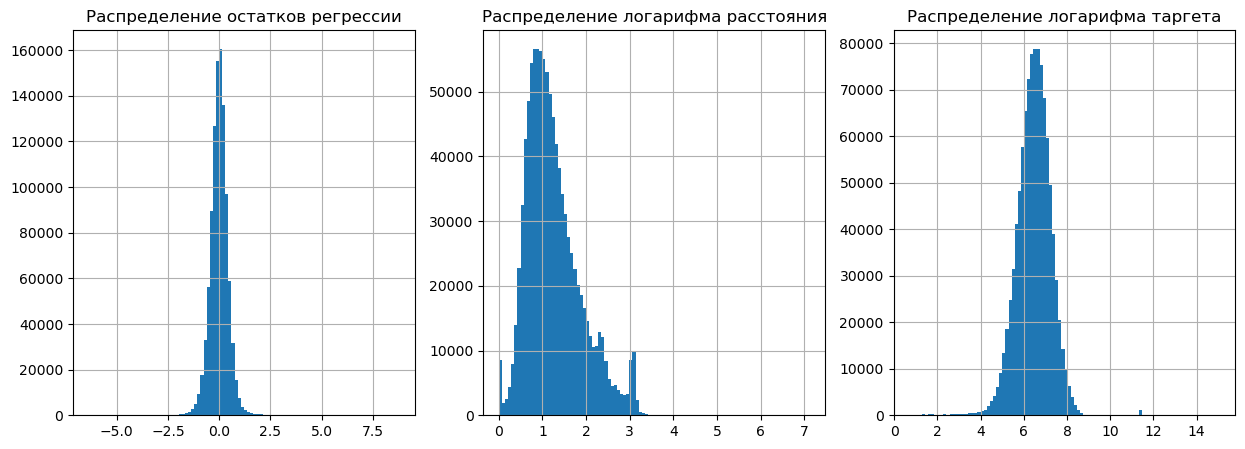

In [62]:
plt.figure(figsize = (15, 5))

# подсчитаем остатки регрессии, 3 признака мы удалили из предыдущего пункта, 
# поэтому просто возьмем резы модели из части 2, мы там предсказывали так же X_train_2

plt.subplot(1,3,1)
plt.title('Распределение остатков регрессии')
plt.hist(y_train-y_pred_train_r2, bins = 100)
plt.grid();

plt.subplot(1,3,2)
plt.title('Распределение логарифма расстояния')
plt.hist(X_train.log_haversine, bins = 100)
plt.grid();

plt.subplot(1,3,3)
plt.title('Распределение логарифма таргета')
plt.hist(y_train, bins = 100)
plt.grid();


In [63]:
train_df, test_df = train_test_split(df, test_size = 0.3, random_state=42)
num_cols = ['log_haversine', 'hour', 'day_num', 'log_trip_duration']

q3 = np.quantile(train_df[num_cols], 0.75, axis = 0)
q1 = np.quantile(train_df[num_cols], 0.25, axis = 0)
iqr = q3-q1
train_df.shape #размеры до 

(1021050, 15)

In [64]:
train_df = train_df[(((train_df[num_cols]<=q3+1.5*iqr)&(train_df[num_cols]>=q1-1.5*iqr)).sum(axis = 1) == 4)]
train_df.shape

(976159, 15)

In [65]:
# потеряно проблемных строк
1021050 - 976159

44891

Восстановим нашу дф таблицу

In [66]:
kek = train_df.index.to_list()+test_df.index.to_list()
df = df.loc[kek]
df.head(3)

,log_trip_duration,dow,month,hour,is_jump,day_num,log_haversine,probka,free_ride,start_in_ken,finist_in_ken,start_in_lagvard,finist_in_lagvard,pickup_cell,dropoff_cell
1011257,6.739337,1,5,9,False,124,0.816774,True,False,False,False,False,False,5.0,8.0
178550,6.909753,4,1,16,False,1,1.758549,True,False,False,False,False,False,5.0,-1.0
551460,6.955593,6,4,13,False,115,2.136659,False,True,False,False,False,True,-1.0,-1.0


Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие).

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

Бинарные признаки немного несбалансированы, другие категориальные ок, объединять что-либо смысла нет

In [67]:
draft_df = df.copy()
X, y = draft_df.drop('log_trip_duration', axis = 1), draft_df.log_trip_duration
X.shape

(1413753, 14)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [69]:
# с прошлого раза обновились признаки, минус 3

cat_cols = ['probka', 'free_ride', 'start_in_ken', 'finist_in_ken', 'start_in_lagvard', 
            'finist_in_lagvard', 'dow', 'month', 'is_jump', 'pickup_cell', 'dropoff_cell']
num_cols = ['log_haversine', 'hour', 'day_num']

preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='if_binary'), cat_cols)])

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regression', Ridge())])

pipeline.fit(X_train, y_train)
y_pred_test_r4 = pipeline.predict(X_test)
y_pred_train_r4 = pipeline.predict(X_train)

In [70]:
print(f'RMSLE Train_4: {rmsle(y_train, y_pred_train_r4)}')
print(f'RMSLE Test_4: {rmsle(y_test, y_pred_test_r4)}')

RMSLE Train_4: 0.4382768300423542
RMSLE Test_4: 0.4377980051644963


**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [71]:
X_train.shape[1] # признаков было до кодирования

14

In [72]:
pipeline = Pipeline([('preprocessing', preprocessor)]) 
pipeline.fit(X_train, y_train)
pipeline.transform(X_train).shape[1] # признаков стало после кодирования

49

Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [73]:
from sklearn.linear_model import Lasso

preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='if_binary'), cat_cols)])

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regression', Lasso())])

pipeline.fit(X_train, y_train)
y_pred_test_r5 = pipeline.predict(X_test)
y_pred_train_r5 = pipeline.predict(X_train)

In [74]:
print(f'RMSLE Train_5: {rmsle(y_train, y_pred_train_r5)}')
print(f'RMSLE Test_5: {rmsle(y_test, y_pred_test_r5)}')

RMSLE Train_5: 0.71759072797064
RMSLE Test_5: 0.7168895066596318


Разбейте _обучающую выборку_ на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [75]:
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, y_train, test_size=0.2, 
                                                                    random_state=42)
pipeline = Pipeline([('preprocessing', preprocessor)]) 
pipeline.fit(X_train_val, y_train_val)
X_train_val = pipeline.transform(X_train_val)
X_test_val = pipeline.transform(X_test_val)
X_test_test = pipeline.transform(X_test)

In [76]:
alphas = np.logspace(-3, 1, 10) 

def lasso_rmsle(alpha):
    model = Lasso(alpha=alpha)
    model.fit(X_train_val, y_train_val)
    y_val_pred = model.predict(X_test_val)
    return rmsle(y_test_val, y_val_pred)

In [77]:
vectorized_lasso_rmsle = np.vectorize(lasso_rmsle)
results = vectorized_lasso_rmsle(alphas)
results

array([0.43859502, 0.4425912 , 0.44621573, 0.45435537, 0.47592481,
       0.50060944, 0.66173781, 0.71604898, 0.71604898, 0.71604898])

In [78]:
best_alpha = alphas[np.argmin(results)]

pipeline = Pipeline([('regression', Lasso(best_alpha))])

pipeline.fit(X_train_val, y_train_val)
y_pred_test_r6 = pipeline.predict(X_test_test)

In [79]:
print(f'RMSLE Test_6: {rmsle(y_test, y_pred_test_r6)}')

RMSLE Test_6: 0.4391149140341304


Сохраните наилучшее значение, как бенчмарк на будущее

In [80]:
best_rmsle = rmsle(y_test, y_pred_test_r6)
best_rmsle

0.4391149140341304

Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [81]:
def lasso_null_weights(alpha):
    model = Lasso(alpha=alpha)
    model.fit(X_train_val, y_train_val)
    cnt = (model.coef_ == 0).sum()
    return cnt

In [82]:
vectorized_lasso_nw= np.vectorize(lasso_null_weights)
null_weights = vectorized_lasso_nw(alphas)
null_weights

array([20, 30, 41, 44, 48, 48, 48, 49, 49, 49])

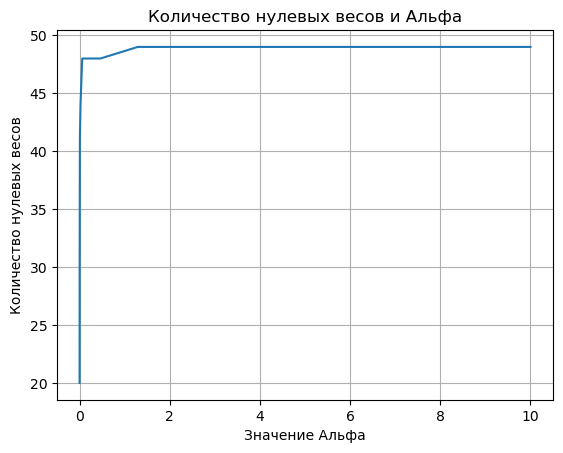

In [83]:
plt.title('Количество нулевых весов и Альфа')
plt.ylabel('Количество нулевых весов')
plt.xlabel('Значение Альфа')
plt.plot(alphas, null_weights);
plt.grid()


In [84]:
total_features = X_train_val.shape[1] # всего столько признаков
total_features

49

In [85]:
alhpa_half = alphas[(null_weights>=total_features/2)][0]

pipeline = Pipeline([('regression', Lasso(alhpa_half))])

pipeline.fit(X_train_val, y_train_val)
y_pred_test_r7 = pipeline.predict(X_test_test)

In [86]:
print(f'RMSLE Test_7: {rmsle(y_test, y_pred_test_r7)}')

# мин ошибка, если захотим избавиться от половины признаков

RMSLE Test_7: 0.44306587318274576


<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [87]:
X_train['route'] = (X_train.pickup_cell).astype('int').astype('str')+ '-' +(X_train.dropoff_cell).astype('int').astype('str')
pairs = X_train.route.value_counts()[:100].index
keys = np.arange(1,101)
routes = pd.Series(keys, index=pairs)

In [88]:
def add_route(X):
    X['route'] = (X.pickup_cell).astype('int').astype('str')+ '-' +(X.dropoff_cell).astype('int').astype('str')
    X['cat_routes'] = np.where(X['route'].isin(routes.index), X['route'].map(routes), -1)
    X.drop('route', axis = 1, inplace = True)
    return X

In [89]:
X_train = add_route(X_train)
X_test = add_route(X_test)
X_train.head(3)

,dow,month,hour,is_jump,day_num,log_haversine,probka,free_ride,start_in_ken,finist_in_ken,start_in_lagvard,finist_in_lagvard,pickup_cell,dropoff_cell,cat_routes
278378,4,5,20,False,134,1.336973,True,False,False,False,False,False,11.0,2.0,-1.0
120498,4,5,7,False,141,0.831991,True,False,False,False,False,False,11.0,8.0,48.0
308070,0,5,15,False,151,1.205811,True,False,False,False,False,False,-1.0,-1.0,1.0


Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [90]:
cat_cols = ['probka', 'free_ride', 'start_in_ken', 'finist_in_ken', 'start_in_lagvard', 
            'finist_in_lagvard', 'dow', 'month', 'is_jump', 'pickup_cell', 'dropoff_cell', 'cat_routes']
num_cols = ['log_haversine', 'hour', 'day_num']

preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='if_binary'), cat_cols)])

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regression', Ridge())])

pipeline.fit(X_train, y_train)
y_pred_test_r8 = pipeline.predict(X_test)
y_pred_train_r8 = pipeline.predict(X_train)

In [91]:
print(f'RMSLE Train: {rmsle(y_train, y_pred_train_r8)}')
print(f'RMSLE Test: {rmsle(y_test, y_pred_test_r8)}')

RMSLE Train: 0.43331624365136234
RMSLE Test: 0.43255885092573265


**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут).

In [92]:
# train = add_route(train)


# def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
#     a = haversine_array(lat1, lng1, lat1, lng2)
#     b = haversine_array(lat1, lng1, lat2, lng1)
#     return a + b


# семинарский код выше

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [93]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**.

Разумеется, погружаться в feature engineering можно ещё очень долго. Ваша задача - придумать какие-то новые признаки, которые сделают модель ещё лучше!! За улучшение функционала ошибки на каждые 0.005 на тестовой выборке относительно `best_rmsle` будет даваться 0.5 бонусных балла. Всего за этот пункт можно получить до 2 бонусных баллов.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Какие могут быть идеи для вдохновения:

1. Трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения, по аналогии с квадратной сеткой  
> Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.    

2. Мы пока что никак не использовали историчность и взаимосвязь в данных, хотя информация о том, что было ранее в эти/похожие дни тоже может пригодиться. Попробуйте поискать соседей и/или построить агрегации, например, при помощи groupby, посчитайте какие-либо статистики в пределах какого-то окна (подберите всё это сами, постарайтесь, чтобы это было что-то разумное), и присоедините к основному датафрейму
> Важно: учтите, что разных вариантов агрегаций и статистик существует очень много. Не стесняйтесь выкидывать фичи, которые вам не нравятся (помните про свойство Lasso), используйте эффективные способы хранения данных ([wink](https://www.kaggle.com/code/demche/polars-memory-usage-optimization)-[wink](https://docs.scipy.org/doc/scipy/reference/sparse.html))

3. В конце концов можно использовать альтернативные способы преобразования данных. Например, использовать другой scaler, другую кодировку категориальных фичей, другие гиперпараметры и пр. Но помните, что на данный момент мы ограничены только `Ridge` и `Lasso`

In [94]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.